In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Exercise 2:

Consider a hospital that needs to prioritize which patients to take in. They have the following dataset of past patients that came into their ER feeling ill. This dataset includes the outcomes in the absence of further treatment as well as other information known about the patient.

In the past the hospital did not have a cardiology department. However, they just received a new grant from the Ministry of Health to establish a cardiology department (as part of the government's initiative to bring AI to hospitals). Create a model that predicts whether, without treatment, a patient will die in the next six months.

In [2]:
survival_history_matrix = pd.read_csv('features_churn_matrix_ex2.csv')
survival_history_matrix.head()

,is_male,num_prev_internations,has_genetic_marker_1,has_genetic_marker_2,age,BMI,history_family_of_heart_disease,died_within_6_months
0,False,1.0,False,True,52.0,32.0,False,False
1,True,0.0,False,False,58.0,27.0,False,True
2,True,1.0,False,True,61.0,31.0,True,False
3,True,0.0,False,True,55.0,31.0,True,False
4,True,2.0,False,True,62.0,21.0,False,False


In [3]:
survival_history_matrix["Label"] = np.where(survival_history_matrix["died_within_6_months"], 1, 0)
survival_history_matrix["has_genetic_marker_1"] = np.where(survival_history_matrix["has_genetic_marker_1"], 1, 0)
survival_history_matrix["has_genetic_marker_2"] = np.where(survival_history_matrix["has_genetic_marker_2"], 1, 0)
survival_history_matrix["is_male"] = np.where(survival_history_matrix["is_male"], 1, 0)
survival_history_matrix["history_family_of_heart_disease"] = np.where(survival_history_matrix["history_family_of_heart_disease"], 1, 0)

In [4]:
X = survival_history_matrix.drop(["Label", "died_within_6_months"], axis = 1)
y = survival_history_matrix["Label"]

In [5]:
y.value_counts()

0    171371
1     28629
Name: Label, dtype: int64

This is an imbalanced dataset.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
from sklearn.preprocessing import MinMaxScaler
norm_features = ['num_prev_internations', 'age', 'BMI']
mm_scaler = MinMaxScaler()

mm_scaler.fit(X_train[norm_features])
X_train[norm_features] = mm_scaler.transform(X_train[norm_features])
X_test[norm_features] = mm_scaler.transform(X_test[norm_features ])

/Users/Yohan/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Yohan/Desktop/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/Yohan/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [8]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_probs = clf.predict_proba(X_test)

## 2A
What's the accuracy and average precision of your model?

In [9]:
from sklearn.metrics import average_precision_score

model_accuracy = clf.score(X_test, y_test)
model_precision = average_precision_score(y_test, y_probs[:,1], average='macro') 
print("model accuracy: {}".format(model_accuracy))
print("model average precision: {}".format(model_precision))

model accuracy: 0.856475
model average precision: 0.22557436893469615


## 2B

A week into the project, you still don't really know what the Head of Department wants from this project and exactly how it will be used. How would you describe your progress and metrics about the model to the Head of Department in 1 minute.

Please write down a sentence or two explaining why you picked that metric

I would explain that my data has been cleaned and that I have already trained some initial models. Logically I would want to minimize my False Negatives using Recall because I feel that minimizing deaths is more important than "wasting" money bringing more people into the hospital than necessary. However, not knowing what is required of the project I would need to provide the F1 score of my model because in any case, for predicting mortality, it is very important to minimize both the False Negatives and False positives without knowing which one to favor. Furthermore the accuracy would not be as good a metric because it does not focus on these optimizations.

In [10]:
from sklearn.metrics import f1_score
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')

/Users/Yohan/Desktop/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.46134475282457343

## 2C

Print the PR Curve

In [11]:
from sklearn.metrics import precision_recall_curve
y_probs = clf.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:, 1])

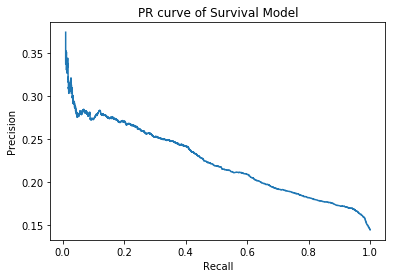

In [12]:
recall_non_zero = recall[recall>=0.01]
precision_non_zero = precision[recall>=0.01]
plt.plot(recall_non_zero,precision_non_zero);
plt.title("PR curve of Survival Model");
plt.xlabel("Recall");
plt.ylabel("Precision");

## 2D

Your Head of Department finally clarifies, and says that your model will be used take in anyone who has over 30% chance of death in the next 6 months, for a checkup  with the doctor (The other 70% will just be schedule to have see a doctor in the near future.). How would you justify your model now? 

Please write down a sentence or two explaining why you picked that metric

Here we want to make sure to save as many lives as possible so we will use recall to minimize false negatives which is sending people to the doctor that need to be taken in. Sending someone to the doctor that will die in the next 6 months is a big failure (False Negative)

In [13]:
TAKEIN_CUTOFF = 0.3
y_pred_takein = np.where(y_probs[:,1]>=TAKEIN_CUTOFF, 1, 0)

In [23]:
from sklearn.metrics import recall_score
takein_precision = recall_score(y_test, y_pred_takein, average='macro') 
print("Dear Boss, {} of the people that will die in the next 6 months would be taken into the hospital.".format(takein_precision))

Dear Boss, 0.5131542526502024 of the people that will die in the next 6 months would be taken into the hospital.


## 2E

A couple of months in, the Head of Department also remembers that the new grant includes a clause specifying that the contract will be cancelled if the Hospital doesn't abide by the following: "For the patients over 60 , 3% of them (the ones with least probability of death in the next six months) should not be referred to a doctor."

How would you say that your model helps the hospital in abiding by this rule?

Please write down a sentence or two explaining why you picked that metric

To minimize the deaths (the goal of a hospital), we would need to make sure that the 3% that are not sent to a doctor have nothing to worry about and will survive the next 6 months. This means that we want to minimize false negatives while looking at the proportion of true negatives being caputured . So we would use negative predictive value which is TN/(TN + FN). It tells us what proportion of the people we don't send actually won't die in the next 6 months.

In [15]:
age60_indices = survival_history_matrix[survival_history_matrix["age"]>=60].index

In [17]:
X_test_indices = X_test['age'].index

In [18]:
age_60_probs = np.array([y_probs[:,1][i] for i in range(len(y_probs)) if X_test_indices[i] in age60_indices])

In [19]:
age_60_y = np.array([y_test.iloc[i] for i in range(y_test.shape[0]) if X_test_indices[i] in age60_indices])

In [20]:
doc_qty = int(len(age_60_probs)*0.97)
doc_cutoff = np.partition(age_60_probs, -doc_qty)[-doc_qty]

In [21]:
y_pred_doc = np.where(age_60_probs>=doc_cutoff, 1, 0)

In [22]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix(age_60_y, y_pred_doc)
cm.print_stats()

population: 21646
P: 3095
N: 18551
PositiveTest: 20997
NegativeTest: 649
TP: 3082
TN: 636
FP: 17915
FN: 13
TPR: 0.9957996768982229
TNR: 0.034283866098862595
PPV: 0.14678287374386817
NPV: 0.9799691833590138
FPR: 0.9657161339011374
FDR: 0.8532171262561318
FNR: 0.00420032310177706
ACC: 0.1717638362746004
F1_score: 0.2558525651668604
MCC: 0.06175071626972106
informedness: 0.0300835429970856
markedness: 0.12675205710288195
prevalence: 0.14298253718931905
LRP: 1.0311515381601415
LRN: 0.12251602808343748
DOR: 8.416462354279826
FOR: 0.020030816640986132


We can see from the above report that 98% (NPV) of the 3% that would not be sent to see a doctor would survive the next 6 months. This is a very high proportion which I could show to the department.